In [1]:
!pip install --upgrade --no-deps statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# 계절성 #

*Tunnel Traffic* dataset을 사용하여 계절성을 확인하고, 시계열 예측 모델을 생성합니다.

## 1. 데이터 불러오기

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import util

#tunnel = pd.read_csv("./dataset/tunnel.csv", parse_dates=["Day"])
tunnel = pd.read_csv("tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

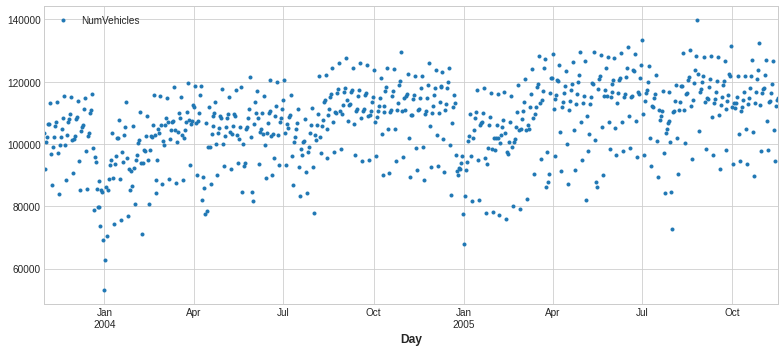

In [3]:
util.init_plt()
tunnel.plot(style=".")

## 2. 계절성 확인하기

### 계절성 플롯(Seasonal plot)

연도별, 주차별 계절성 플롯을 그려봅니다.

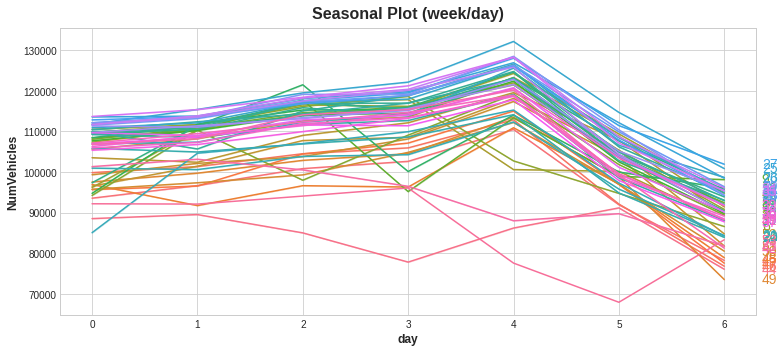

In [4]:
X = tunnel.copy()

# 주차별 계절성 플롯
X["day"] = X.index.dayofweek  # 요일
X["week"] = X.index.week  # 주
util.seasonal_plot(X, y="NumVehicles", period="week", freq="day")

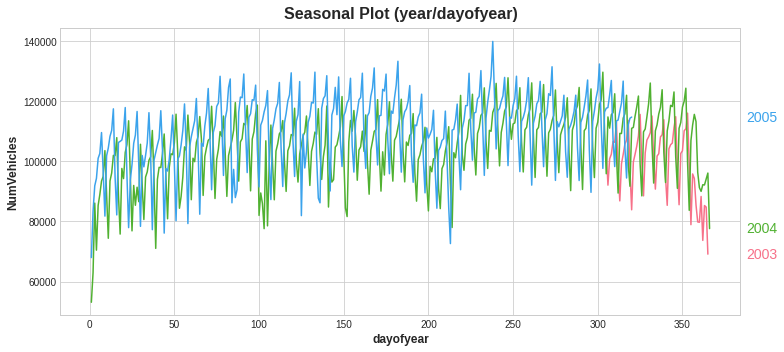

In [5]:
# 연도별 계절성 플롯
X["dayofyear"] = X.index.dayofyear # 연도의 시작일을 기준으로 며칠이 지났는지 설정
X["year"] = X.index.year # 연도
util.seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear");

###  스펙트럼 분석(Periodogram)

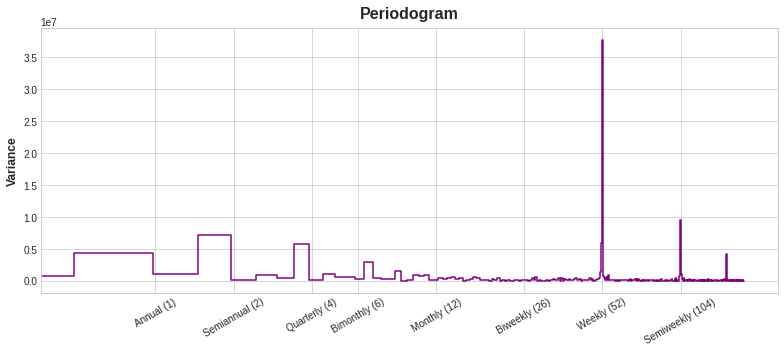

In [6]:
util.plot_periodogram(tunnel.NumVehicles);

## 3. 데이터 전처리

푸리에 속성 생성

In [7]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [8]:
fourier = CalendarFourier(freq="A", order=10) # 연간("A"nnual) 계절성을 반영한 10 sin/cos 쌍

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,              
    order=1,                   
    seasonal=True,             
    additional_terms=[fourier],
    drop=True,                 
)

X = dp.in_sample() 
y = tunnel["NumVehicles"]

In [12]:
X.columns

Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)',
       'sin(4,freq=A-DEC)', 'cos(4,freq=A-DEC)', 'sin(5,freq=A-DEC)',
       'cos(5,freq=A-DEC)', 'sin(6,freq=A-DEC)', 'cos(6,freq=A-DEC)',
       'sin(7,freq=A-DEC)', 'cos(7,freq=A-DEC)', 'sin(8,freq=A-DEC)',
       'cos(8,freq=A-DEC)', 'sin(9,freq=A-DEC)', 'cos(9,freq=A-DEC)',
       'sin(10,freq=A-DEC)', 'cos(10,freq=A-DEC)'],
      dtype='object')

## 4. 학습

선형회귀 모델

In [13]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

## 5. 예측

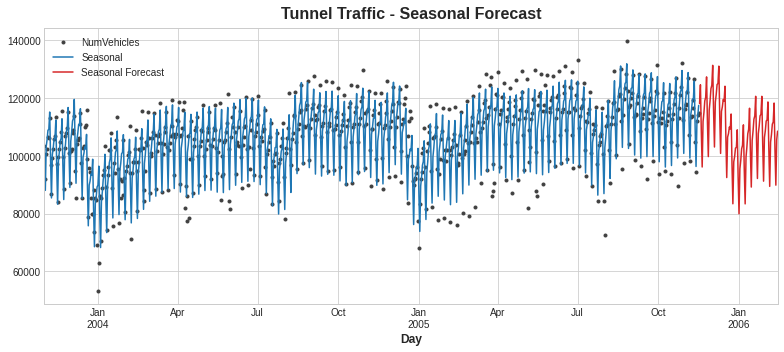

In [14]:
y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()